## Walmart Store Sales Prediction

Objective: The objective is predicting store sales using historical markdown data.

In [176]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
import pandas_profiling 
import seaborn as sns


from datetime import datetime

import statsmodels.api as sm
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Data Pre-Processing 

In [232]:
train = pd.read_csv('data/train.csv')
feature = pd.read_csv('data/features.csv')
test = pd.read_csv('data/test.csv')
stores = pd.read_csv('data/stores.csv')


# For Output_excel file...
writer=pd.ExcelWriter('Walmart Store Sales Prediction output.xlsx', engine='xlsxwriter')

    Merging the DataSet 
      -(train+Store+Feature) 
      -(test+Store+Feature)

In [233]:
train_bt = pd.merge(train,stores) 
train = pd.merge(train_bt,feature)
#
test_bt = pd.merge(test,stores)
test= pd.merge(test_bt,feature)

In [234]:
train.head(2)          

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [235]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573
1,1,2,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573


In [236]:
print train.info()
print "*****************************************"
print test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       150681 non-null float64
MarkDown2       111248 non-null float64
MarkDown3       137091 non-null float64
MarkDown4       134967 non-null float64
MarkDown5       151432 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB
None
*****************************************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 15 columns):
Store           115064 non-nu

#### Data Description

##### 1. Training Data

In [237]:
numeric_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_train=[key for key in dict(train.dtypes) if dict(train.dtypes)[key] in ['object']]
# Train Numerical Data
train_num=train[numeric_var_train]

# Train Categorical Data
train_cat=train[cat_var_train]
print numeric_var_train
print cat_var_train

['CPI', 'Temperature', 'Unemployment', 'Weekly_Sales', 'MarkDown4', 'Dept', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown5', 'Store', 'Size']
['Date', 'Type']


In [238]:
# Creating Data audit Report
# Use a general function that returns multiple values    
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
 
num_summary=train_num.apply(lambda x: var_summary(x)).T
num_summary.to_excel(writer,'Numeric_variable Summary',index=True)
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,421570.0,0.0,7.217360e+07,171.201947,182.31878,39.159276,1.533449e+03,126.064,126.111903,126.496258,128.823806,132.022667,182.31878,212.416993,219.444244,221.941558,225.473509,227.232807
Temperature,421570.0,0.0,2.533217e+07,60.090059,62.09000,18.447931,3.403262e+02,-2.060,18.300000,27.310000,33.980000,46.680000,62.09000,74.280000,83.580000,87.270000,92.810000,100.140000
Unemployment,421570.0,0.0,3.355819e+06,7.960289,7.86600,1.863296,3.471872e+00,3.879,4.156000,5.326000,5.965000,6.891000,7.86600,8.572000,9.816000,12.187000,14.180000,14.313000
Weekly_Sales,421570.0,0.0,6.737219e+09,15981.258123,7612.03000,22711.183519,5.157979e+08,-4988.940,5.000000,59.974500,291.097000,2079.650000,7612.03000,20205.852500,42845.673000,61201.951000,106479.586000,693099.360000
MarkDown4,134967.0,286603.0,4.566161e+08,3383.168256,1481.31000,6292.384031,3.959410e+07,0.220,3.970000,28.760000,108.710000,504.220000,1481.31000,3595.040000,7871.420000,12645.960000,35785.260000,67474.850000
Dept,421570.0,0.0,1.865882e+07,44.260317,37.00000,30.492054,9.297654e+02,1.000,1.000000,4.000000,7.000000,18.000000,37.00000,74.000000,92.000000,95.000000,98.000000,99.000000
Fuel_Price,421570.0,0.0,1.416908e+06,3.361027,3.45200,0.458515,2.102356e-01,2.472,2.565000,2.653000,2.720000,2.933000,3.45200,3.738000,3.917000,4.029000,4.202000,4.468000
MarkDown1,150681.0,270889.0,1.091898e+09,7246.420196,5347.45000,8291.221345,6.874435e+07,0.270,17.760000,149.190000,375.200000,2240.270000,5347.45000,9210.900000,15282.470000,21801.350000,41524.030000,88646.760000
MarkDown2,111248.0,310322.0,3.709708e+08,3334.628621,192.00000,9475.357325,8.978240e+07,-265.760,-0.990000,1.950000,6.980000,41.600000,192.00000,1926.940000,8549.740000,16497.470000,50366.600000,104519.540000
MarkDown3,137091.0,284479.0,1.973317e+08,1439.421384,24.60000,9623.078290,9.260364e+07,-29.100,0.060000,0.650000,1.650000,5.080000,24.60000,103.990000,400.090000,1059.900000,63143.290000,141630.610000


In [239]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=train_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,421570,421570
NMISS,0,0
ColumnsNames,2011-12-23 3027 2011-11-25 3021 2011-12-...,A 215478 B 163495 C 42597 Name: Type...


##### 2. Testing Data

In [240]:
numeric_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_test=[key for key in dict(test.dtypes) if dict(test.dtypes)[key] in ['object']]
# Train Numerical Data
test_num=test[numeric_var_test]

# Train Categorical Data
test_cat=test[cat_var_test]
print numeric_var_test
print cat_var_test

['CPI', 'Temperature', 'Unemployment', 'MarkDown4', 'Dept', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown5', 'Store', 'Size']
['Date', 'Type']


In [241]:
num_summary=test_num.apply(lambda x: var_summary(x)).T
#num_summary.to_excel(writer,'Numeric_variable Summary',index=True)
num_summary.head()

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
CPI,76902.0,38162.0,1.360868e+07,176.961347,192.304445,41.239967,1.700735e+03,131.236226,131.279355,131.4784,132.030871,138.402033,192.304445,223.244532,225.898059,227.784753,228.729864,228.976456
Temperature,115064.0,0.0,6.206760e+06,53.941804,54.470000,18.724153,3.505939e+02,-7.290000,11.440000,23.9800,29.970000,39.820000,54.470000,67.350000,79.480000,83.820000,92.140000,101.950000
Unemployment,76902.0,38162.0,5.282193e+05,6.868733,6.806000,1.583427,2.507242e+00,3.684000,3.879000,3.9320,5.049000,5.771000,6.806000,8.036000,8.934000,9.910000,10.199000,10.199000
MarkDown4,102176.0,12888.0,3.429250e+08,3356.219071,840.940000,7570.501545,5.731249e+07,0.220000,2.610000,16.9600,37.360000,155.460000,840.940000,3096.920000,7674.410000,14191.010000,44739.280000,65344.640000
Dept,115064.0,0.0,5.101883e+06,44.339524,37.000000,30.656410,9.398155e+02,1.000000,1.000000,4.0000,7.000000,18.000000,37.000000,74.000000,92.000000,95.000000,98.000000,99.000000


In [242]:
def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

cat_summary=test_cat.apply(lambda x: cat_summary(x))
cat_summary

,Date,Type
N,115064,115064
NMISS,0,0
ColumnsNames,2012-12-21 3002 2012-12-07 2989 2012-12-...,"A 58713 B 44500 C 11851 Name: Type, d..."


In [243]:
pandas_profiling.ProfileReport(train)

Number of variables,16
Number of observations,421570
Total Missing (%),0.0%
Total size in memory,51.9 MiB
Average record size in memory,129.0 B
Numeric,13
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


In [244]:
pandas_profiling.ProfileReport(test)

Number of variables,15
Number of observations,115064
Total Missing (%),0.0%
Total size in memory,13.3 MiB
Average record size in memory,121.0 B
Numeric,12
Categorical,2
Boolean,1
Date,0
Text (Unique),0
Rejected,0


###### Correlation

In [245]:
train_corr=pd.DataFrame(train.corr())
train_corr.to_excel(writer,'Train_Data Corr',index=True)
train_corr.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828,-0.002312,-0.000120,0.085251,0.024130,0.060385,0.045414,0.090362,-0.020921,-0.025864
IsHoliday,-0.000548,0.000916,0.012774,1.000000,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238


In [246]:
test_corr=pd.DataFrame(test.corr())
#test_corr.to_excel(writer,'Test_Data Corr',index=True)
test_corr.head()

,Store,Dept,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Store,1.000000,0.019627,-0.001166,-0.186845,-0.043495,0.153425,-0.091707,-0.041370,-0.025177,0.010331,0.010419,-0.214872,0.250321
Dept,0.019627,1.000000,0.001249,0.001502,0.003970,0.000554,-0.002353,0.001292,0.000247,0.002510,0.000776,-0.006336,0.004087
IsHoliday,-0.001166,0.001249,1.000000,-0.000443,-0.187428,-0.126443,0.355257,0.265402,0.496062,0.289700,-0.019386,-0.001475,0.010288
Size,-0.186845,0.001502,-0.000443,1.000000,-0.061256,0.055088,0.309614,0.157526,0.050088,0.155448,0.103681,-0.002916,-0.001988
Temperature,-0.043495,0.003970,-0.187428,-0.061256,1.000000,0.073938,-0.168899,-0.324280,-0.049771,-0.059583,0.003937,0.280861,0.022136


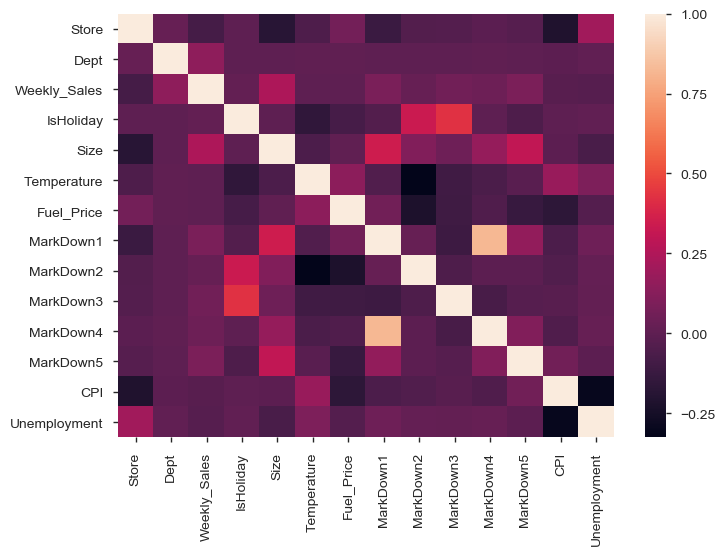

In [247]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(train.corr())

<big> -Markdowns are Highly Correlated.

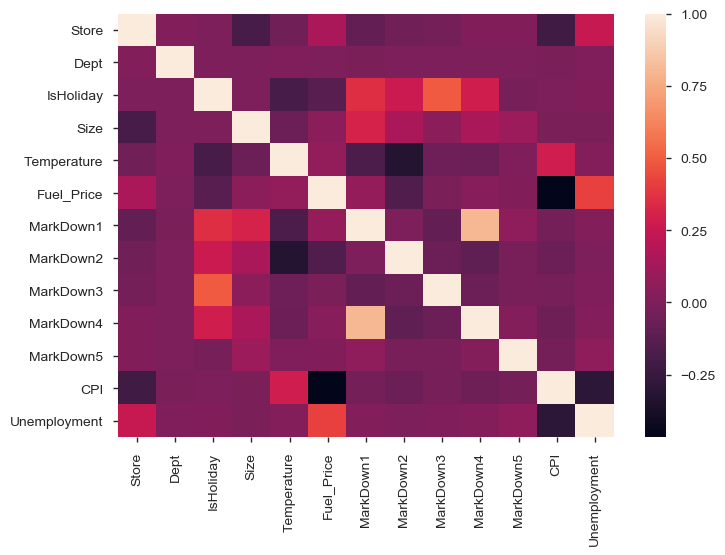

In [248]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(test.corr())

<big> -Markdown 4 is  Highly Correlated to Markdown 1

___

### Data Exploratory Analysis

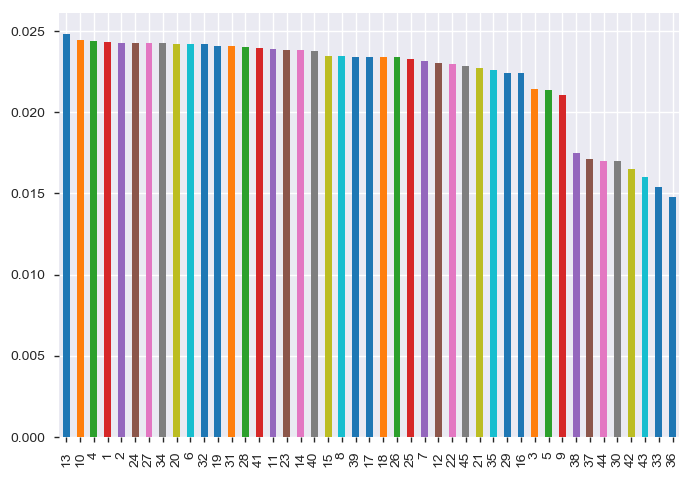

In [249]:
train['Store'].value_counts(normalize=True).plot(kind = 'bar',fig=(4,5))

<big> -The above graph shows that There are more number of Store 13 and very less number of Store 36

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


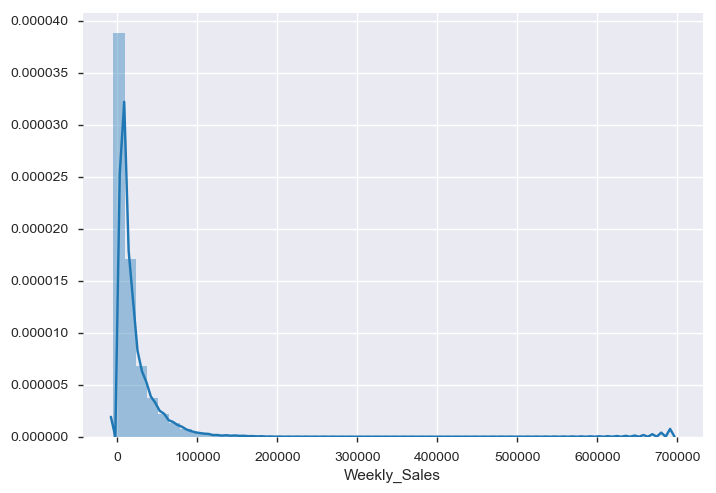

In [250]:
sns.distplot(train.Weekly_Sales)

###### Store Size vs Sales

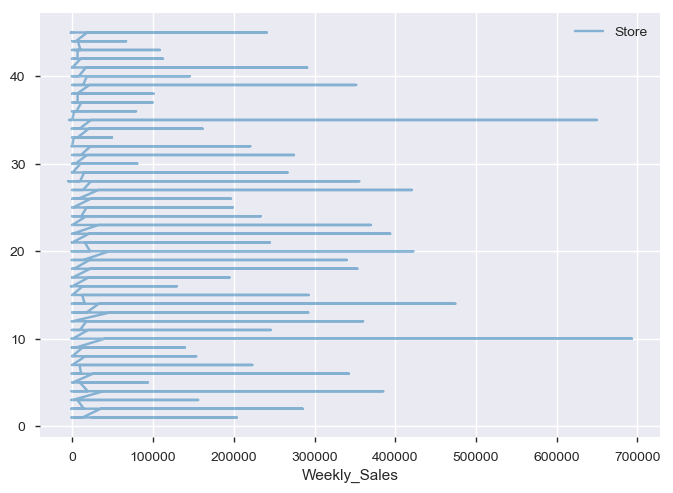

In [251]:
train.plot(kind='line', x='Weekly_Sales', y='Store', alpha=0.5)

<big> From this plot, we notice that Store 10 has the highest Sales

###### Sales vs Type

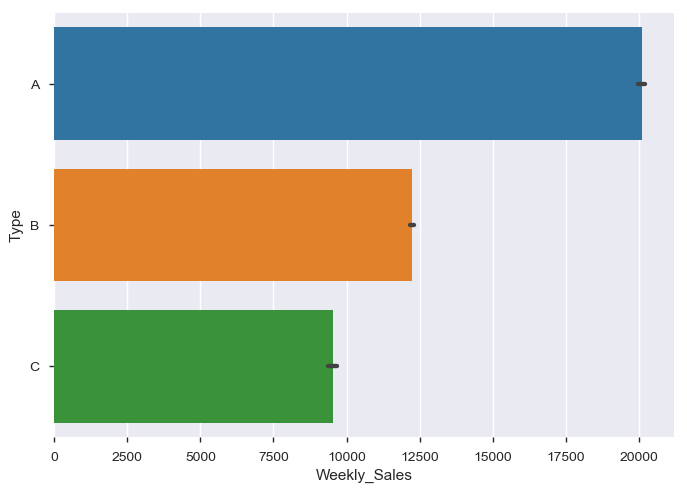

In [252]:
#tips = sns.load_dataset('train')
sns.barplot(x=train["Weekly_Sales"],y=train["Type"])

<big> From this plot, we notice that 'type C' stores have fewer sales and 'type A' stores have more sales in general.

###### Sales vs Deptartment

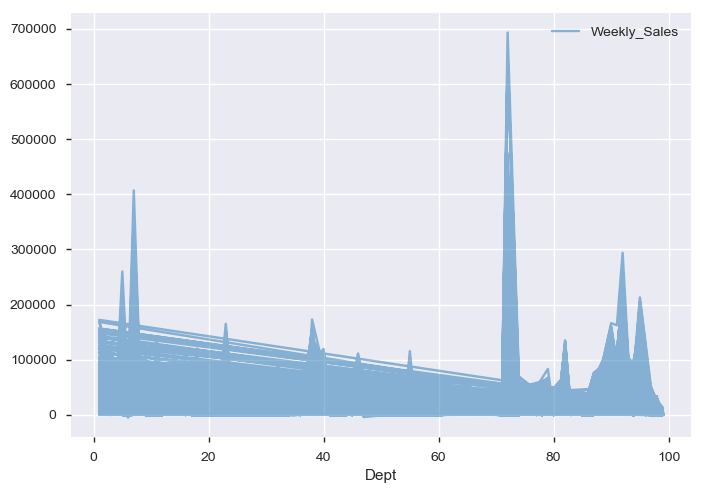

In [253]:
train.plot(kind='line', x='Dept', y='Weekly_Sales', alpha=1.5,fig=(4,5))

<big> From this plot, we notice Deptartment with the highest sales lies between Dept 60 and 80

____

#### Missing Value Treatment

In [254]:
print train.isnull().sum()
print "*"*30
print test.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64
******************************
Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


    Imputing it with its mean

In [255]:
test['CPI']=test.groupby(['Dept'])['CPI'].transform(lambda x: x.fillna(x.mean()))
test['Unemployment']=test.groupby(['Dept'])['Unemployment'].transform(lambda x: x.fillna(x.mean()))

    Other Missing Value Treatment like Markdown
    Imputing it with Zero(No Markdown)

In [256]:
train=train.fillna(0)
test=test.fillna(0)

<big> We can probably safely fill all missing values with zero. For the markdowns this means that there was no markdown. 

In [257]:
print train.isnull().sum()
print "*"*30
print test.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64
******************************
Store           0
Dept            0
Date            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64


###### Outlier Treatment

In [258]:
train.Weekly_Sales=np.where(train.Weekly_Sales>100000, 100000,train.Weekly_Sales)

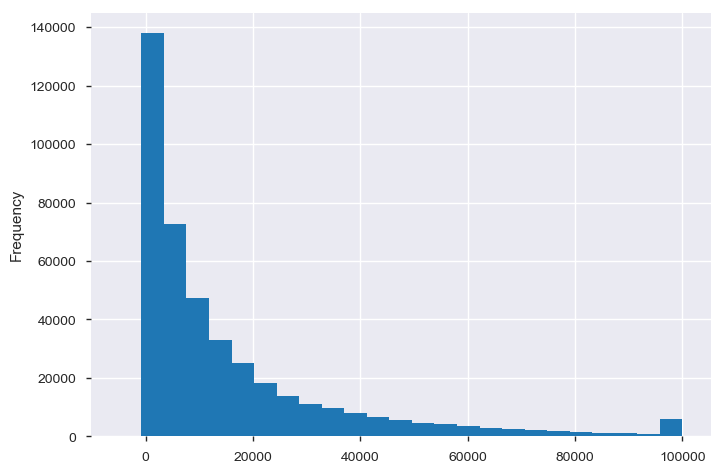

In [259]:
train.Weekly_Sales.plot.hist(bins=25)

_______________

### Feature Extraction
In this section, we select the appropriate features to train our classifier. Here, we create new features based on existing features. We also convert categorical features into numeric form.

###### Date Feature

In [260]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
Type            421570 non-null object
Size            421570 non-null int64
Temperature     421570 non-null float64
Fuel_Price      421570 non-null float64
MarkDown1       421570 non-null float64
MarkDown2       421570 non-null float64
MarkDown3       421570 non-null float64
MarkDown4       421570 non-null float64
MarkDown5       421570 non-null float64
CPI             421570 non-null float64
Unemployment    421570 non-null float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 71.9+ MB


In [261]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [262]:
# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

test['Date_dayofweek'] =test['Date'].dt.dayofweek
test['Date_month'] =test['Date'].dt.month 
test['Date_year'] =test['Date'].dt.year
test['Date_day'] =test['Date'].dt.day 

In [263]:
print train.Type.value_counts()
print "*"*30
print test.Type.value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64
******************************
A    58713
B    44500
C    11851
Name: Type, dtype: int64


In [264]:
print train.IsHoliday.value_counts()
print "*"*30
print test.IsHoliday.value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64
******************************
False    106136
True       8928
Name: IsHoliday, dtype: int64


In [265]:
train_test_data = [train, test]

    Converting Categorical Variable 'Type' into Numerical Variable 
    For A=1 , B=2, C=3

In [266]:
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_test_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

    Converting Categorical Variable 'IsHoliday' into Numerical Variable 

In [267]:
type_mapping = {False: 0, True: 1}
for dataset in train_test_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

    Creating Extra Holiday Variable.
    If that week comes under extra holiday then 1(=Yes) else 2(=No)

Making New Holiday Variable Based on Given Data....

In [268]:
train['Super_Bowl'] = np.where((train['Date']==datetime(2010, 2, 12)) | (train['Date']==datetime(2011, 2, 11)) | (train['Date']==datetime(2012, 2, 10)) | (train['Date']==datetime(2013, 2, 8)),1,0)
train['Labour_Day'] = np.where((train['Date']==datetime(2010, 9, 10)) | (train['Date']==datetime(2011, 9, 9)) | (train['Date']==datetime(2012, 9, 7)) | (train['Date']==datetime(2013, 9, 6)),1,0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)
#........................................................................
test['Super_Bowl'] = np.where((test['Date']==datetime(2010, 2, 12)) | (test['Date']==datetime(2011, 2, 11)) | (test['Date']==datetime(2012, 2, 10)) | (test['Date']==datetime(2013, 2, 8)),1,0)
test['Labour_Day'] = np.where((test['Date']==datetime(2010, 9, 10)) | (test['Date']==datetime(2011, 9, 9)) | (test['Date']==datetime(2012, 9, 7)) | (test['Date']==datetime(2013, 9, 6)),1,0)
test['Thanksgiving'] = np.where((test['Date']==datetime(2010, 11, 26)) | (test['Date']==datetime(2011, 11, 25)) | (test['Date']==datetime(2012, 11, 23)) | (test['Date']==datetime(2013, 11, 29)),1,0)
test['Christmas'] = np.where((test['Date']==datetime(2010, 12, 31)) | (test['Date']==datetime(2011, 12, 30)) | (test['Date']==datetime(2012, 12, 28)) | (test['Date']==datetime(2013, 12, 27)),1,0)


In [269]:
# Altering the isHoliday value depending on these new holidays...
train['IsHoliday']=train['IsHoliday']|train['Super_Bowl']|train['Labour_Day']|train['Thanksgiving']|train['Christmas']
test['IsHoliday']=test['IsHoliday']|test['Super_Bowl']|test['Labour_Day']|test['Thanksgiving']|test['Christmas']

In [270]:
print train.Christmas.value_counts()
print train.Super_Bowl.value_counts()
print train.Thanksgiving.value_counts()
print train.Labour_Day.value_counts()

0    415624
1      5946
Name: Christmas, dtype: int64
0    412675
1      8895
Name: Super_Bowl, dtype: int64
0    415611
1      5959
Name: Thanksgiving, dtype: int64
0    412709
1      8861
Name: Labour_Day, dtype: int64


In [271]:
print test.Christmas.value_counts()
print test.Super_Bowl.value_counts()
print test.Thanksgiving.value_counts()
print test.Labour_Day.value_counts()

0    112076
1      2988
Name: Christmas, dtype: int64
0    112100
1      2964
Name: Super_Bowl, dtype: int64
0    112088
1      2976
Name: Thanksgiving, dtype: int64
0    115064
Name: Labour_Day, dtype: int64


In [272]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant..
# Droping the Extra holiday variables because its redundant..
dp=['Super_Bowl','Labour_Day','Thanksgiving','Christmas']
train.drop(dp,axis=1,inplace=True)
test.drop(dp,axis=1,inplace=True)

### Feature Selection

In [273]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 20 columns):
Store             421570 non-null int64
Dept              421570 non-null int64
Date              421570 non-null datetime64[ns]
Weekly_Sales      421570 non-null float64
IsHoliday         421570 non-null int64
Type              421570 non-null int64
Size              421570 non-null int64
Temperature       421570 non-null float64
Fuel_Price        421570 non-null float64
MarkDown1         421570 non-null float64
MarkDown2         421570 non-null float64
MarkDown3         421570 non-null float64
MarkDown4         421570 non-null float64
MarkDown5         421570 non-null float64
CPI               421570 non-null float64
Unemployment      421570 non-null float64
Date_dayofweek    421570 non-null int64
Date_month        421570 non-null int64
Date_year         421570 non-null int64
Date_day          421570 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(9)
memory usag

####    Droping irrevelent variable:
    -Since we have imputed markdown variables therefore we will not be removing the all markdown variables.
    -Removing MarkDown5 because its Highly Skewed

In [274]:
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)
test=test.drop(features_drop, axis=1)

In [281]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,4,2,2010,5


In [282]:
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2012-11-02,0,1,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,4,11,2012,2
1,1,2,2012-11-02,0,1,151315,55.32,3.386,6766.44,5147.7,50.82,3639.9,4,11,2012,2


In [277]:
# Converting all float var int integer..
#for var in train:
#    if train[var].dtypes == float:
#        train[var]=train[var].astype(int)
        
#for var in test:
#    if test[var].dtypes == float:
#test[var]=test[var].astype(int)

____

### Classification & Accuracy
    Define training and testing set

In [278]:
#### train X= Exery thing except Weekly_Sales
train_X=train.drop(['Weekly_Sales','Date'], axis=1)

#### train Y= Only Weekly_Sales 
train_y=train['Weekly_Sales'] 
test_X=test.drop('Date',axis=1).copy()

train_X.shape, train_y.shape, test_X.shape

((421570, 15), (421570L,), (115064, 15))

### Building models & comparing their RMSE values

#### 1.Linear Regression

In [279]:
## Methood 1..
clf = LinearRegression()
clf.fit(train_X, train_y)
y_pred_linear=clf.predict(test_X)
acc_linear=round( clf.score(train_X, train_y) * 100, 2)
print ('scorbe:'+str(acc_linear) + ' percent')

scorbe:8.86 percent


#### 2. Random Forest

In [280]:
clf = RandomForestRegressor(n_estimators=100)
clf.fit(train_X, train_y)
y_pred_rf=clf.predict(test_X)
acc_rf= round(clf.score(train_X, train_y) * 100, 2)
print ("Accuracy: %i %% \n"%acc_rf)

Accuracy: 99 % 



#### 3. Decision Tree

In [285]:
clf=DecisionTreeRegressor()
clf.fit(train_X, train_y)
y_pred_dt= clf.predict(test_X)
acc_dt = round( clf.score(train_X, train_y) * 100, 2)
print (str(acc_dt) + ' percent')

100.0 percent


#### Comparing Models
Let's compare the accuracy score of all the regression models used above.

In [286]:
models = pd.DataFrame({
    'Model': ['Linear Regression','Random Forest','Decision Tree'],
    
    'Score': [acc_linear, acc_rf,acc_dt]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,100.00
1,Random Forest,99.77
0,Linear Regression,8.86


**Predicting Sales value for test data based on highest score model.**

In [287]:
# Prediction value using Random Forest model..
submission = pd.DataFrame({
        "Store_Dept_Date": test.Store.astype(str)+'_'+test.Dept.astype(str)+'_'+test.Date.astype(str),
        "Weekly_Sales": y_pred_rf
    })

submission.to_csv('weekly_sales predicted.csv', index=False)
submission.to_excel(writer,'Weekly_sales Pred',index=False)

In [290]:
submission.head()

,Store_Dept_Date,Weekly_Sales
0,1_1_2012-11-02,33056.3451
1,1_2_2012-11-02,47608.3694
2,1_3_2012-11-02,10736.5681
3,1_4_2012-11-02,37907.2111
4,1_5_2012-11-02,32680.1213


    ************* THE END **************************************************************************************************